In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
# file_path = './drive/My Drive/636/dataset/part6/dataset_all_dropped.csv'
# dataset = pd.read_csv(file_path, index_col=0)

In [0]:
train_path = './drive/My Drive/636/dataset/part6/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part6/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

In [52]:
print(trainset.shape, testset.shape)

(127308, 158) (22325, 158)


In [0]:
testset = testset.reset_index(drop=True)
trainset = trainset.reset_index(drop=True)

In [6]:
dataset.shape

(149733, 158)

In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[2:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X = create_segments(dataset, 10)

In [0]:
y = dataset['label'].to_numpy()

In [12]:
print(X.shape, y.shape)

(149733, 10, 156) (149733,)


In [25]:
type(X)

numpy.ndarray

In [26]:
type(y)

numpy.ndarray

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
# def save_3d(data):
#   # Write the array to disk
#   with open('./drive/My Drive/636/dataset/part5/sliced.txt', 'w') as outfile:
#       # I'm writing a header here just for the sake of readability
#       # Any line starting with "#" will be ignored by numpy.loadtxt
#       outfile.write('# Array shape: {0}\n'.format(data.shape))

#       # Iterating through a ndimensional array produces slices along
#       # the last axis. This is equivalent to data[i,:,:] in this case
#       for data_slice in data:

#           # The formatting string indicates that I'm writing out
#           # the values in left-justified columns 7 characters in width
#           # with 2 decimal places.  
#           # np.savetxt(outfile, data_slice, fmt='%-7.2f')
#           np.savetxt(outfile, data_slice)

#           # Writing out a break to indicate different slices...
#           outfile.write('# New slice\n')

In [0]:
# def read_3d(data):
#   # Read the array from disk
#   new_data = np.loadtxt('./drive/My Drive/636/dataset/part5/sliced.txt')

#   # Note that this returned a 2D array!
#   print new_data.shape

#   # However, going back to 3D is easy if we know the 
#   # original shape of the array
#   new_data = new_data.reshape((97069, 50, 156))

#   # Just to check that they're the same...
#   assert np.all(new_data == data)

In [0]:
# save_3d(X)

Create train and test set

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119786, 10, 156) (29947, 10, 156) (119786,) (29947,)


In [0]:
print(type(X_train), type(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Build model

**model1**

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [16]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten, Bidirectional
from keras.callbacks import History, EarlyStopping

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def create_model_1():
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [30]:
model = create_model_1()
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 86451 samples, validate on 21613 samples
Epoch 1/100
 - 52s - loss: 0.5515 - acc: 0.7202 - val_loss: 0.6467 - val_acc: 0.6410
Epoch 2/100
 - 49s - loss: 0.4932 - acc: 0.7655 - val_loss: 0.4880 - val_acc: 0.7805
Epoch 3/100
 - 50s - loss: 0.4644 - acc: 0.7803 - val_loss: 0.5560 - val_acc: 0.7341
Epoch 4/100
 - 50s - loss: 0.4397 - acc: 0.7946 - val_loss: 0.4050 - val_acc: 0.8115
Epoch 5/100
 - 50s - loss: 0.4164 - acc: 0.8070 - val_loss: 0.5305 - val_acc: 0.7635
Epoch 6/100
 - 50s - loss: 0.3977 - acc: 0.8175 - val_loss: 0.4932 - val_acc: 0.7952
Epoch 7/100
 - 50s - loss: 0.3835 - acc: 0.8242 - val_loss: 0.3864 - val_acc: 0.8239
Epoch 8/100
 - 49s - loss: 0.3682 - acc: 0.8329 - val_loss: 0.4131 - val_acc: 0.8104
Epoch 9/100
 - 49s - loss: 0.3550 - acc: 0.8382 - val_loss: 0.5150 - val_acc: 0.7598
Epoch 10/

In [0]:
model.summary()

In [34]:
score

[0.1905941534555077, 0.922271192073822]

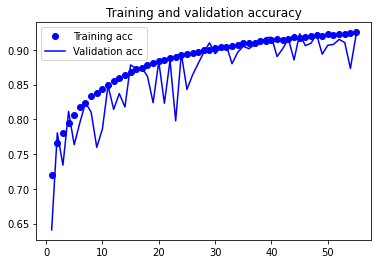

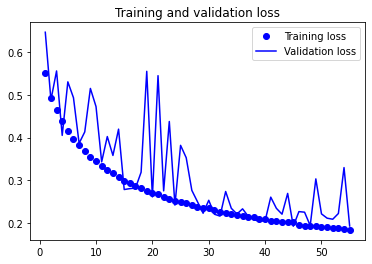

In [33]:
draw(history)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
def create_model_2():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 64))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
#                            verbose=2, mode='min')
# callbacks_list = [early_stop]

In [18]:
# create model
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 76,161
Trainable params: 76,161
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.w

In [19]:
score

[0.27144050713633877, 0.886232316493988]

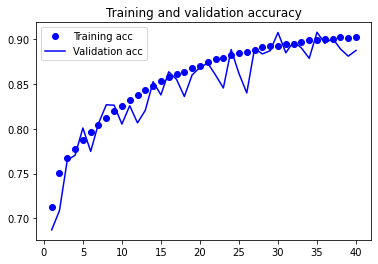

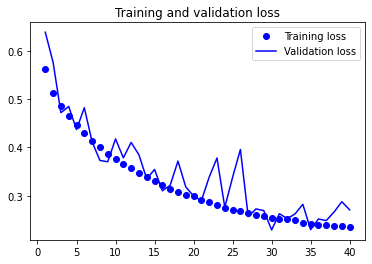

In [22]:
draw(history)

In [24]:
# create model
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
_________________________________________________________________
Train on 95828 samples, validate on 23958 samples
Epoch 1/100
 - 44s - loss: 0.5661 - acc: 0.7072 - val_loss: 0.5189

In [25]:
score

[0.3368620639379249, 0.8535412549972534]

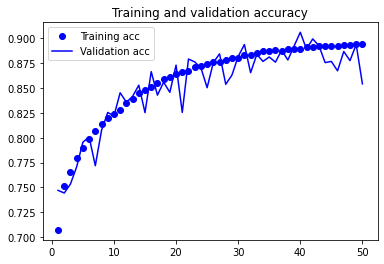

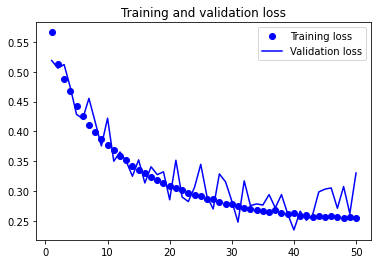

In [26]:
draw(history)

fixed dataset

In [55]:
model = create_model_1()
history = model.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)

Train on 101846 samples, validate on 25462 samples
Epoch 1/100
 - 44s - loss: 0.5792 - acc: 0.6982 - val_loss: 0.8587 - val_acc: 0.5859
Epoch 2/100
 - 43s - loss: 0.5278 - acc: 0.7400 - val_loss: 1.0972 - val_acc: 0.5770
Epoch 3/100
 - 42s - loss: 0.4959 - acc: 0.7606 - val_loss: 1.2309 - val_acc: 0.5430
Epoch 4/100
 - 42s - loss: 0.4669 - acc: 0.7753 - val_loss: 1.1104 - val_acc: 0.5398
Epoch 5/100
 - 42s - loss: 0.4441 - acc: 0.7884 - val_loss: 1.0366 - val_acc: 0.5596
Epoch 6/100
 - 42s - loss: 0.4285 - acc: 0.7957 - val_loss: 1.3331 - val_acc: 0.4480
Epoch 7/100
 - 42s - loss: 0.4147 - acc: 0.8033 - val_loss: 1.6238 - val_acc: 0.4618
Epoch 8/100
 - 41s - loss: 0.4018 - acc: 0.8120 - val_loss: 1.2953 - val_acc: 0.4964
Epoch 9/100
 - 41s - loss: 0.3881 - acc: 0.8197 - val_loss: 1.3635 - val_acc: 0.5014
Epoch 10/100
 - 41s - loss: 0.3762 - acc: 0.8289 - val_loss: 1.2620 - val_acc: 0.5062
Epoch 11/100
 - 41s - loss: 0.3666 - acc: 0.8338 - val_loss: 1.4781 - val_acc: 0.4522
Epoch 00011:

In [40]:
score

[1.8814200358416864, 0.5294574499130249]

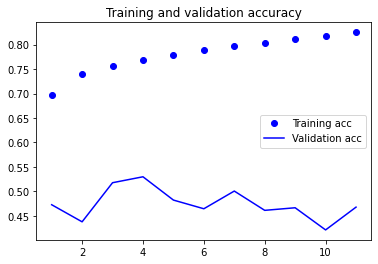

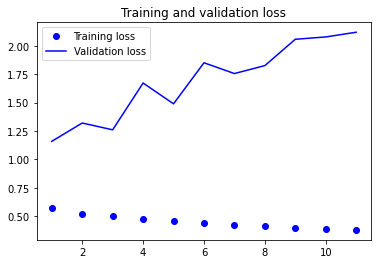

In [41]:
draw(history)

In [57]:
# create model
model = create_model_2()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2)
score = model.evaluate(X_test, y_test, verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10, 128)           20096     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 201,153
Trainable params: 201,153
Non-trainable params: 0
_________________________________________________________________
Train on 101846 samples, validate on 25462 samples
Epoch 1/100
 - 46s - loss: 0.5704 - acc: 0.7047 - val_loss: 0.6

KeyboardInterrupt: ignored

In [58]:
score

[1.0481356264442239, 0.5813214182853699]

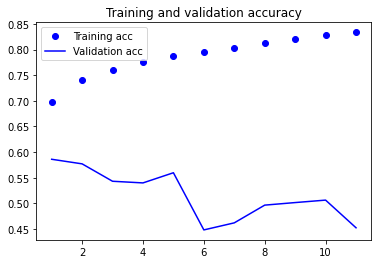

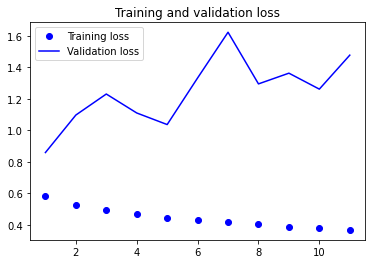

In [59]:
draw(history)

model
3


In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 50
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_3():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 64))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
#                            verbose=2, mode='min')
# callbacks_list = [early_stop]

# create model
model = create_model_3()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.2, verbose=2)
score = model.evaluate(X_test, y_test, verbose=2)